In [4]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

In [5]:
df = pd.read_csv('../input/stage_1_train_labels.csv')

In [6]:
df[1:10]

,patientId,x,y,width,height,Target
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [7]:
patientId = df['patientId'][0]

In [8]:
patientId

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [9]:
dcm_file = '../input/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

In [10]:
print(dcm_data)


(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [11]:
import PIL

In [12]:
im = dcm_data.pixel_array

In [13]:
print(type(im))

<class 'numpy.ndarray'>


In [15]:
print(im.dtype)

uint8


In [16]:
print(im.shape)

(1024, 1024)


In [28]:
def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]
    parsed = {}
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../input/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []
            }
            
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
                
    return parsed


In [29]:
parsed = parse_data(df)

In [30]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])


{'dicom': '../input/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [38]:
def draw(data):
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    im = np.stack([im] * 3,axis=2)
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im = im, box=box, rgb=rgb, stroke=6)
        
    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')
    
def overlay_box(im, box, rgb, stroke=1):
    box = [int(b) for b in box]
    y1,x1,height, width = box
    y2 = y1 + height
    x2 = x1 + width
    im[y1:y1+stroke, x1:x2] = rgb
    im[y2:y2+stroke, x1:x2] = rgb
    im[y1:y2, x1:x1+stroke] = rgb
    im[y1:y2, x2:x2+stroke] = rgb
    
    return im

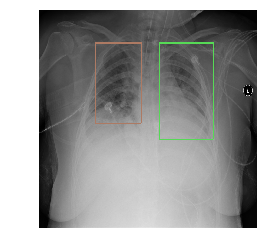

In [43]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [40]:
df_detailed = pd.read_csv('../input/stage_1_detailed_class_info.csv')
print(df_detailed[1:10])

                              patientId                         class
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity


In [34]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'Lung Opacity': 8964, 'Normal': 8525, 'No Lung Opacity / Not Normal': 11500}


In [41]:
dcm_file


'../input/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

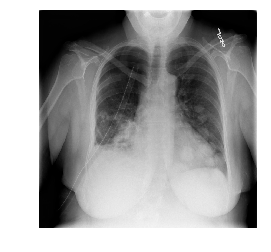

In [45]:
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

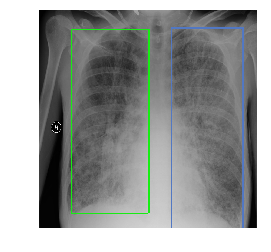

In [50]:
draw(parsed['3e62e51c-befb-4a66-b28e-fc469b19e4a8'])

In [48]:
print(df_detailed[0:10])

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
